In [15]:
import csv

import numpy as np
import tensorflow as tf
from sklearn import model_selection
import os

In [16]:
RANDOM_SEED = 42
NUM_CLASSES = 38
dataset = 'keypoint_classifier/keypoint_all-letters_all.csv'
model_save_path = 'keypoint_classifier/GRU_model_moving.hdf5'

In [17]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 15)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [18]:

X_train = X_train[:, None, :]
print(X_train.shape)

(4300, 1, 56)


In [19]:
X_test = X_test[:, None, :]
print(X_test.shape)

(1434, 1, 56)


In [20]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(GRU(50, return_sequences=True, input_shape=(1,56)))
model.add(Dropout(0.2))
model.add(GRU(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [21]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 1, 50)             16200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 gru_5 (GRU)                 (None, 100)               45600     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 38)                3838      
                                                                 
Total params: 65,638
Trainable params: 65,638
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
15/27 [===============>..............] - ETA: 0s - loss: 3.6191 - accuracy: 0.0396  
Epoch 1: saving model to keypoint_classifier\GRU_model_moving.hdf5
27/27 [==============================] - 3s 22ms/step - loss: 3.5995 - accuracy: 0.0541 - val_loss: 3.5535 - val_accuracy: 0.0895
Epoch 2/500
18/27 [===================>..........] - ETA: 0s - loss: 3.4887 - accuracy: 0.1254
Epoch 2: saving model to keypoint_classifier\GRU_model_moving.hdf5
27/27 [==============================] - 0s 5ms/step - loss: 3.4587 - accuracy: 0.1215 - val_loss: 3.3530 - val_accuracy: 0.1256
Epoch 3/500
14/27 [==============>...............] - ETA: 0s - loss: 3.2530 - accuracy: 0.1434
Epoch 3: saving model to keypoint_classifier\GRU_model_moving.hdf5
27/27 [==============================] - 0s 6ms/step - loss: 3.1821 - accuracy: 0.1555 - val_loss: 3.0328 - val_accuracy: 0.1570
Epoch 4/500
27/27 [==============================] - ETA: 0s - loss: 2.8230 - accuracy: 0.2317
Epoch 4: saving model to keyp

45/45 [==============================] - 0s 1ms/step


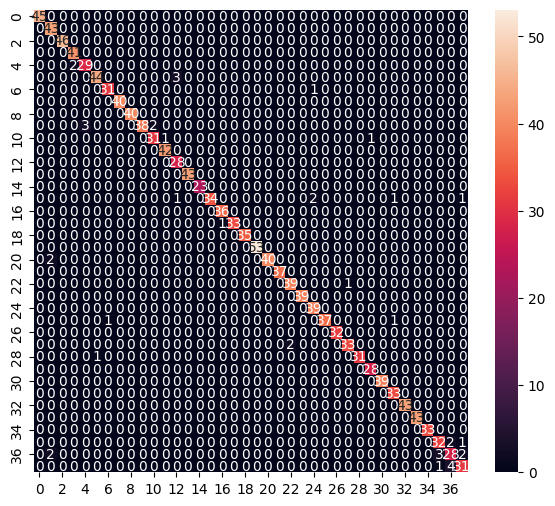

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.91      1.00      0.96        43
           2       1.00      1.00      1.00        46
           3       0.95      1.00      0.98        41
           4       0.91      0.94      0.92        31
           5       0.98      0.94      0.96        47
           6       0.97      0.97      0.97        32
           7       1.00      1.00      1.00        40
           8       1.00      1.00      1.00        40
           9       1.00      0.88      0.94        43
          10       0.94      0.94      0.94        33
          11       0.98      1.00      0.99        42
          12       0.88      1.00      0.93        28
          13       1.00      1.00      1.00        43
          14       1.00      1.00      1.00        23
          15       1.00      0.87      0.93        39
          16       0.97      1.00      0.99        36
     

In [23]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [24]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        45
           1      0.915     1.000     0.956        43
           2      1.000     1.000     1.000        46
           3      0.953     1.000     0.976        41
           4      0.906     0.935     0.921        31
           5      0.978     0.936     0.957        47
           6      0.969     0.969     0.969        32
           7      1.000     1.000     1.000        40
           8      1.000     1.000     1.000        40
           9      1.000     0.884     0.938        43
          10      0.939     0.939     0.939        33
          11      0.977     1.000     0.988        42
          12      0.875     1.000     0.933        28
          13      1.000     1.000     1.000        43
          14      1.000     1.000     1.000        23
          15      1.000     0.872     0.932        39
          16      0.973     1.000     0.986        36
          17      1.000    

Text(0.5, 1.0, 'Loss')

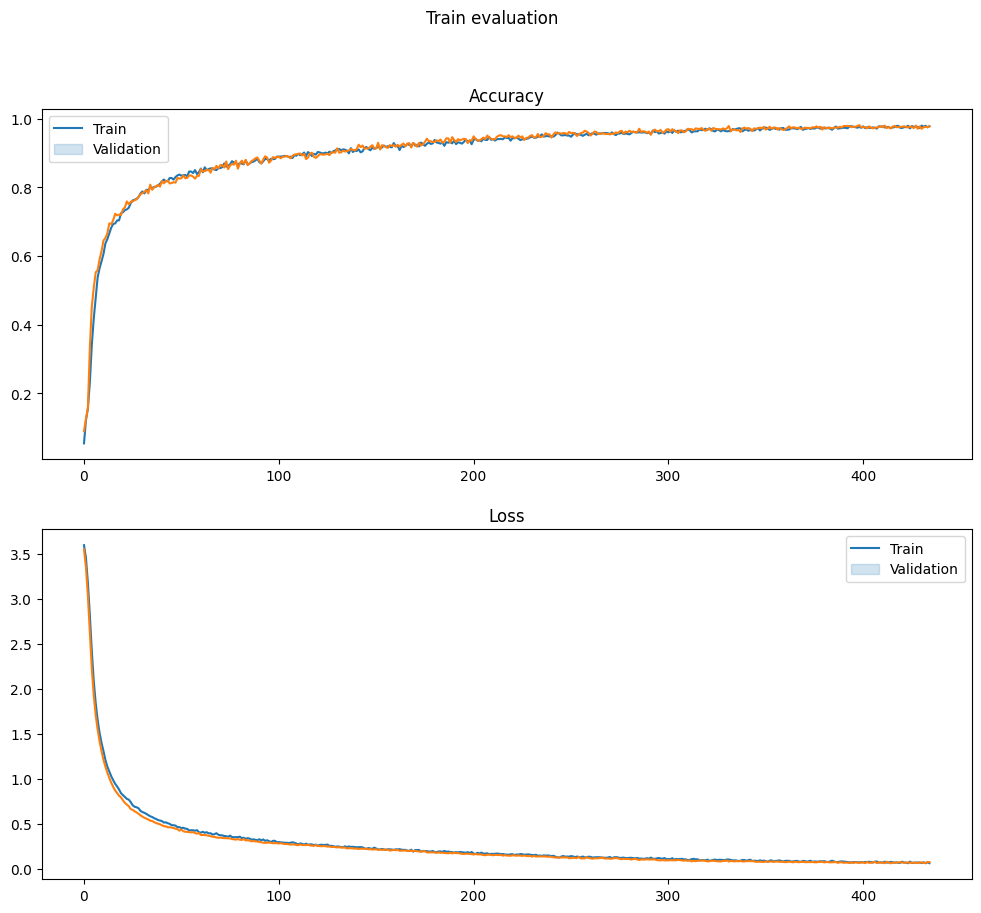

In [25]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [26]:
model_save_path = 'keypoint_classifier/LSTM_model_moving.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(1,56)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [27]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             21400     
                                                                 
 dropout_6 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               60400     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 38)                3838      
                                                                 
Total params: 85,638
Trainable params: 85,638
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
14/27 [==============>...............] - ETA: 0s - loss: 3.6334 - accuracy: 0.0569 
Epoch 1: saving model to keypoint_classifier\LSTM_model_moving.hdf5
27/27 [==============================] - 3s 24ms/step - loss: 3.6284 - accuracy: 0.0735 - val_loss: 3.6124 - val_accuracy: 0.1477
Epoch 2/500
15/27 [===============>..............] - ETA: 0s - loss: 3.5956 - accuracy: 0.1193
Epoch 2: saving model to keypoint_classifier\LSTM_model_moving.hdf5
27/27 [==============================] - 0s 5ms/step - loss: 3.5712 - accuracy: 0.1183 - val_loss: 3.4960 - val_accuracy: 0.1244
Epoch 3/500
15/27 [===============>..............] - ETA: 0s - loss: 3.4163 - accuracy: 0.1141
Epoch 3: saving model to keypoint_classifier\LSTM_model_moving.hdf5
27/27 [==============================] - 0s 5ms/step - loss: 3.3425 - accuracy: 0.1163 - val_loss: 3.1774 - val_accuracy: 0.1640
Epoch 4/500
15/27 [===============>..............] - ETA: 0s - loss: 3.0840 - accuracy: 0.1667
Epoch 4: saving model to ke

45/45 [==============================] - 1s 1ms/step


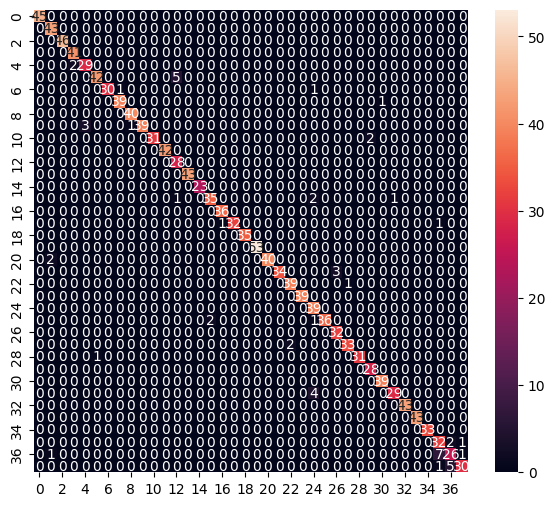

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.93      1.00      0.97        43
           2       1.00      1.00      1.00        46
           3       0.95      1.00      0.98        41
           4       0.91      0.94      0.92        31
           5       0.98      0.89      0.93        47
           6       1.00      0.94      0.97        32
           7       0.97      0.97      0.97        40
           8       0.98      1.00      0.99        40
           9       1.00      0.91      0.95        43
          10       1.00      0.94      0.97        33
          11       1.00      1.00      1.00        42
          12       0.82      1.00      0.90        28
          13       1.00      1.00      1.00        43
          14       1.00      1.00      1.00        23
          15       0.95      0.90      0.92        39
          16       0.97      1.00      0.99        36
     

In [29]:
# callback needs to be done better, but still accuracy 86%
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [30]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        45
           1      0.935     1.000     0.966        43
           2      1.000     1.000     1.000        46
           3      0.953     1.000     0.976        41
           4      0.906     0.935     0.921        31
           5      0.977     0.894     0.933        47
           6      1.000     0.938     0.968        32
           7      0.975     0.975     0.975        40
           8      0.976     1.000     0.988        40
           9      1.000     0.907     0.951        43
          10      1.000     0.939     0.969        33
          11      1.000     1.000     1.000        42
          12      0.824     1.000     0.903        28
          13      1.000     1.000     1.000        43
          14      1.000     1.000     1.000        23
          15      0.946     0.897     0.921        39
          16      0.973     1.000     0.986        36
          17      1.000    

Text(0.5, 1.0, 'Loss')

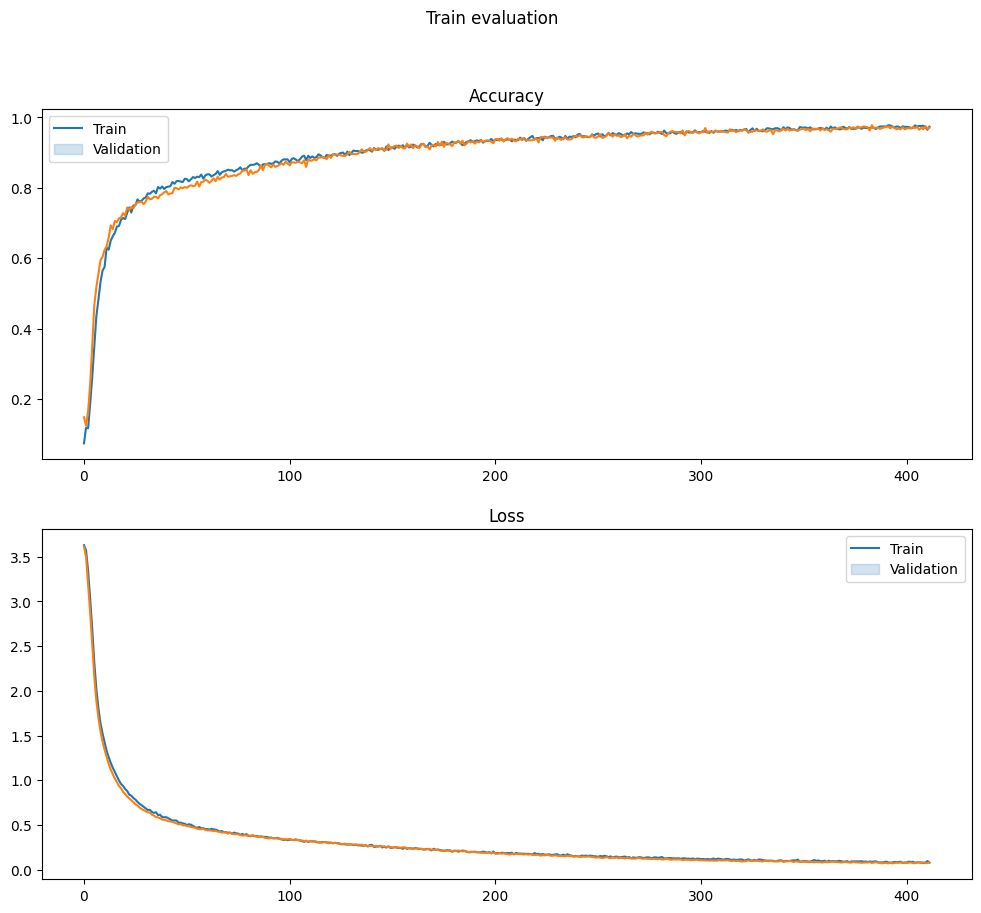

In [31]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [32]:
model_save_path = 'keypoint_classifier/SimpleRNN_model_moving.hdf5'
from keras.layers import SimpleRNN
model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(1,56)))
model.add(Dropout(0.2))
model.add(SimpleRNN(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [33]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 50)             5350      
                                                                 
 dropout_8 (Dropout)         (None, 1, 50)             0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               15100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 38)                3838      
                                                                 
Total params: 24,288
Trainable params: 24,288
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
18/27 [===================>..........] - ETA: 0s - loss: 3.6251 - accuracy: 0.0516 
Epoch 1: saving model to keypoint_classifier\SimpleRNN_model_moving.hdf5
27/27 [==============================] - 2s 14ms/step - loss: 3.5701 - accuracy: 0.0674 - val_loss: 3.3617 - val_accuracy: 0.1256
Epoch 2/500
22/27 [=======================>......] - ETA: 0s - loss: 3.2998 - accuracy: 0.1197
Epoch 2: saving model to keypoint_classifier\SimpleRNN_model_moving.hdf5
27/27 [==============================] - 0s 4ms/step - loss: 3.2710 - accuracy: 0.1323 - val_loss: 3.0909 - val_accuracy: 0.2372
Epoch 3/500
23/27 [========================>.....] - ETA: 0s - loss: 2.9926 - accuracy: 0.2177
Epoch 3: saving model to keypoint_classifier\SimpleRNN_model_moving.hdf5
27/27 [==============================] - 0s 4ms/step - loss: 2.9810 - accuracy: 0.2203 - val_loss: 2.7919 - val_accuracy: 0.3360
Epoch 4/500
22/27 [=======================>......] - ETA: 0s - loss: 2.6940 - accuracy: 0.2994
Epoch 4: sav

45/45 [==============================] - 0s 955us/step


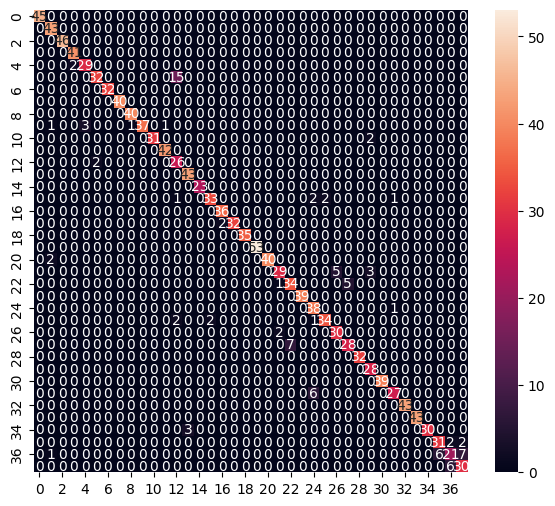

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       0.91      1.00      0.96        43
           2       1.00      1.00      1.00        46
           3       0.95      1.00      0.98        41
           4       0.91      0.94      0.92        31
           5       0.94      0.68      0.79        47
           6       1.00      1.00      1.00        32
           7       1.00      1.00      1.00        40
           8       0.98      1.00      0.99        40
           9       1.00      0.86      0.92        43
          10       1.00      0.94      0.97        33
          11       0.98      1.00      0.99        42
          12       0.59      0.93      0.72        28
          13       0.93      1.00      0.97        43
          14       1.00      1.00      1.00        23
          15       0.94      0.85      0.89        39
          16       0.95      1.00      0.97        36
     

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [36]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        45
           1      0.915     1.000     0.956        43
           2      1.000     1.000     1.000        46
           3      0.953     1.000     0.976        41
           4      0.906     0.935     0.921        31
           5      0.941     0.681     0.790        47
           6      1.000     1.000     1.000        32
           7      1.000     1.000     1.000        40
           8      0.976     1.000     0.988        40
           9      1.000     0.860     0.925        43
          10      1.000     0.939     0.969        33
          11      0.977     1.000     0.988        42
          12      0.591     0.929     0.722        28
          13      0.935     1.000     0.966        43
          14      1.000     1.000     1.000        23
          15      0.943     0.846     0.892        39
          16      0.947     1.000     0.973        36
          17      1.000    

Text(0.5, 1.0, 'Loss')

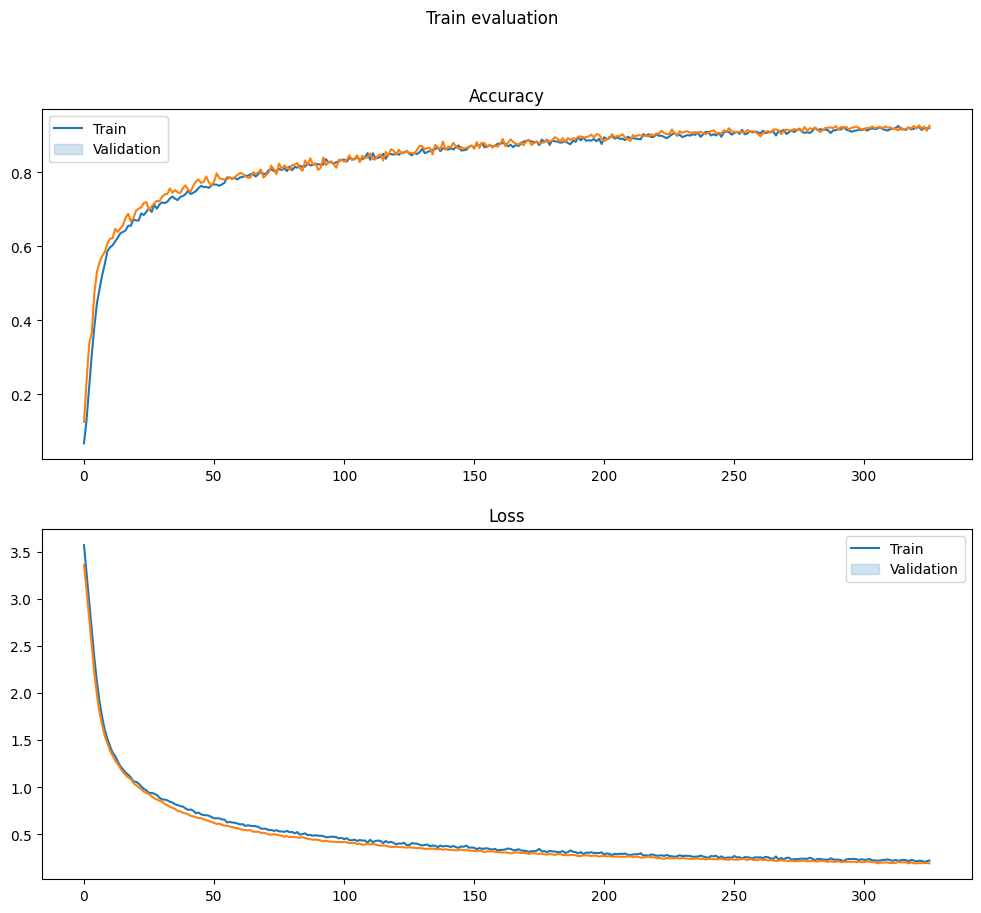

In [37]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them

In [41]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 57)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [42]:
model_save_path = 'keypoint_classifier/FF_model_moving.hdf5'
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from keras.layers import GRU
model = Sequential()
model.add(Dense(256, input_shape=(56,), activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

# model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# callback for early abort
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

 # model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               14592     
                                                                 
 dense_9 (Dense)             (None, 128)               32896     
                                                                 
 dense_10 (Dense)            (None, 38)                4902      
                                                                 
Total params: 52,390
Trainable params: 52,390
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(
    X_train,
    y_train,
    epochs=500,
    batch_size=128,
    validation_split=0.2,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/500
27/27 [==============================] - ETA: 0s - loss: 3.4081 - accuracy: 0.1349
Epoch 1: saving model to keypoint_classifier\FF_model_moving.hdf5
27/27 [==============================] - 1s 8ms/step - loss: 3.4081 - accuracy: 0.1349 - val_loss: 3.1409 - val_accuracy: 0.2012
Epoch 2/500
22/27 [=======================>......] - ETA: 0s - loss: 2.8215 - accuracy: 0.3061
Epoch 2: saving model to keypoint_classifier\FF_model_moving.hdf5
27/27 [==============================] - 0s 4ms/step - loss: 2.7581 - accuracy: 0.3343 - val_loss: 2.4395 - val_accuracy: 0.4012
Epoch 3/500
21/27 [======================>.......] - ETA: 0s - loss: 2.1030 - accuracy: 0.5201
Epoch 3: saving model to keypoint_classifier\FF_model_moving.hdf5
27/27 [==============================] - 0s 5ms/step - loss: 2.0541 - accuracy: 0.5349 - val_loss: 1.8419 - val_accuracy: 0.5186
Epoch 4/500
22/27 [=======================>......] - ETA: 0s - loss: 1.5405 - accuracy: 0.6300
Epoch 4: saving model to keypoint_c

45/45 [==============================] - 0s 854us/step


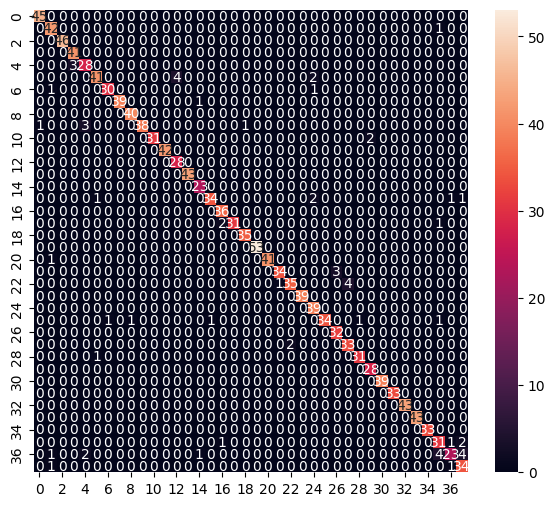

Classification Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       0.91      0.98      0.94        43
           2       1.00      1.00      1.00        46
           3       0.93      1.00      0.96        41
           4       0.85      0.90      0.88        31
           5       0.95      0.87      0.91        47
           6       0.97      0.94      0.95        32
           7       1.00      0.97      0.99        40
           8       0.98      1.00      0.99        40
           9       1.00      0.88      0.94        43
          10       1.00      0.94      0.97        33
          11       1.00      1.00      1.00        42
          12       0.88      1.00      0.93        28
          13       1.00      1.00      1.00        43
          14       0.92      1.00      0.96        23
          15       0.97      0.87      0.92        39
          16       0.92      1.00      0.96        36
     

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [45]:
from sklearn import metrics
flat = y_test.flatten()
flat2 = y_pred.flatten()

# indexes are classifiers
classification = metrics.classification_report(flat, flat2,digits=3)
print(classification)

              precision    recall  f1-score   support

           0      0.978     1.000     0.989        45
           1      0.913     0.977     0.944        43
           2      1.000     1.000     1.000        46
           3      0.932     1.000     0.965        41
           4      0.848     0.903     0.875        31
           5      0.953     0.872     0.911        47
           6      0.968     0.938     0.952        32
           7      1.000     0.975     0.987        40
           8      0.976     1.000     0.988        40
           9      1.000     0.884     0.938        43
          10      1.000     0.939     0.969        33
          11      1.000     1.000     1.000        42
          12      0.875     1.000     0.933        28
          13      1.000     1.000     1.000        43
          14      0.920     1.000     0.958        23
          15      0.971     0.872     0.919        39
          16      0.923     1.000     0.960        36
          17      1.000    

Text(0.5, 1.0, 'Loss')

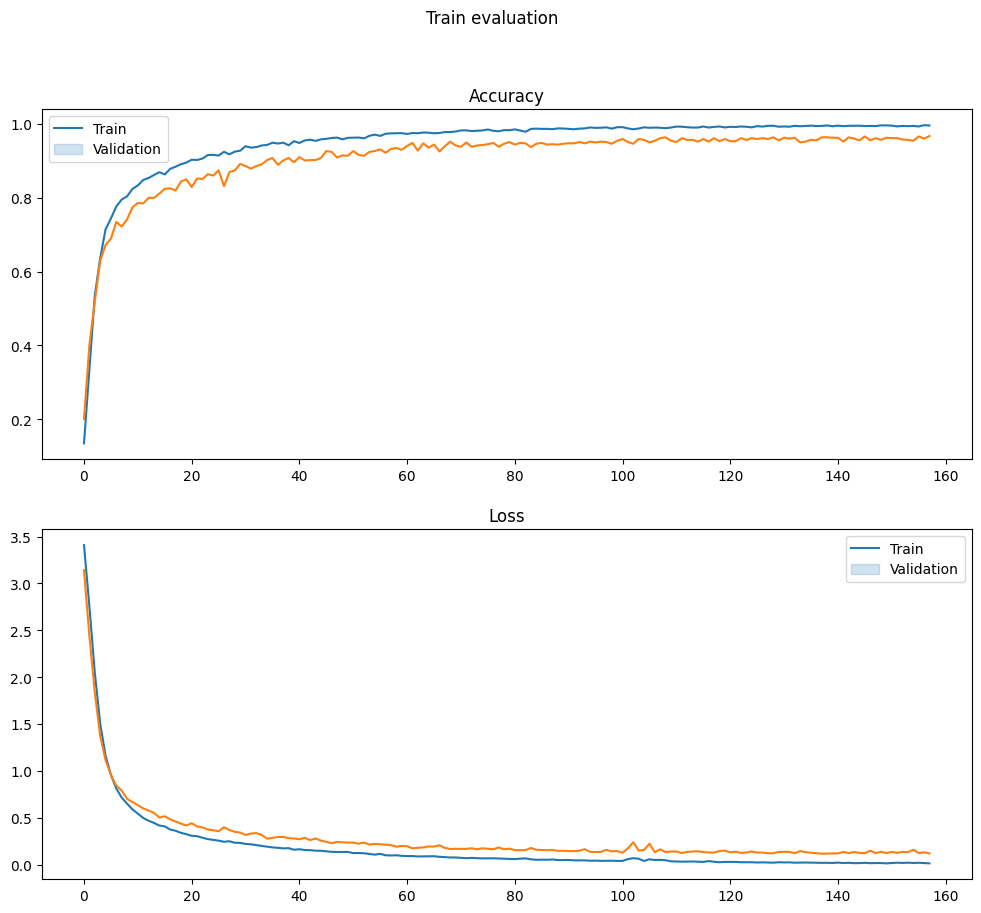

In [46]:
fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')
# xlabel("X axis label")
# ylabel("Y axis label")

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])

ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])

ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
# creating charts and plotting them